# BNN on Single Label Train/ Multiple Label Prediction


### Issue with 0.5 as ppc mean 

## BNN


In [1]:
%matplotlib inline

import theano
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
import lasagne


In [2]:

import data_utils

Train_x, Train_y, Test_x, Test_y = data_utils.load_data()


Train_x = np.asarray(Train_x)
Train_y = np.asarray(Train_y)
Test_x  = np.asarray(Test_x)
Test_y  = np.asarray(Test_y)

## Training and Testing Input

X_train_single = Train_x[200:1700]

X_test_multi = Train_x[:200]
## Training and Testing Output

from sklearn.preprocessing import MultiLabelBinarizer

y = np.load('../behav_Exp/pri_sec_emotion.npy')

from keras.utils import to_categorical

y_train = Train_y[200:1700]

mlb = MultiLabelBinarizer()
y_test = mlb.fit_transform(y)


Using Theano backend.


## Train: X_train_single;y_train   
## Test: X_test_multi;y_test

In [3]:
print X_train_single.shape
print y_train.shape

(1500, 2304)
(1500,)


In [4]:
y.shape



(200, 2)

### Prior Comparsion

1. Normal Prior 

2. Uniform prior 

3. Cauchy Prior

In [13]:
import lasagne

floatX = theano.config.floatX

num_features = 2304
num_classes = 7
total_size = len(y_train)

ann_input = theano.shared(X_train_single)
ann_output = theano.shared(y_train)
ann_input_minibatch = pm.data.Minibatch(X_train_single, batch_size = 50)
ann_output_minibatch = pm.data.Minibatch(y_train, batch_size = 50)

n_hidden_1 = 30
n_hidden_2 = 30

# Initialize random weights between each layer

## Tryint out increase numbers of layer; two layers acc .87
    
    
init_1 = np.random.randn(num_features, n_hidden_1).astype(floatX)
init_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(floatX)
init_out = np.random.randn(n_hidden_2, num_classes).astype(floatX)


# Priors for Weight
with pm.Model() as neural_network:

    c_in_1  = pm.Uniform('r_in_1', -2.5, 2.5)
    c_1_2   = pm.Uniform('r_1_2',  -2.0, 2.0)
    c_2_out = pm.Uniform('r_2_out', -1.5, 1.5)

    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1',0.3, c_in_1, 
                             shape=(num_features, n_hidden_1), 
                    testval = init_1)

    weights_1_2  = pm.Normal('w_1_2',0.2, c_1_2, 
                            shape =(n_hidden_1, n_hidden_2),
                            testval = init_2)

    weights_2_out = pm.Normal('w_2_out',0.3, c_2_out, 
                            shape=(n_hidden_2, num_classes), 
                          testval = init_out)

    # Build neural-network using tanh activation function
    act_in = lasagne.layers.InputLayer(X_train_single.shape, 
                                       input_var=ann_input_minibatch)

    act_1 = lasagne.layers.DenseLayer(act_in, n_hidden_1, 
                                      W=weights_in_1, 
                                      nonlinearity=lasagne.nonlinearities.tanh)

    act_2 = lasagne.layers.DenseLayer(act_1, n_hidden_2, 
                                      W=weights_1_2, 
                                      nonlinearity=lasagne.nonlinearities.tanh)

    act_out = lasagne.layers.DenseLayer(act_2, num_classes, 
                                        W=weights_2_out,
                                        nonlinearity=lasagne.nonlinearities.sigmoid)

    # Method 1: use model.get_output(from lasagne or Theano)
    # prediction = lasagne.layers.get_output(act_out)

    # Method 2: add one determininstic layer right after the final dense connection layer
    prediction = pm.Deterministic('p', lasagne.layers.get_output(act_out))

    #p = pm.Deterministic('p', T.nnet.softmax(net_out))
    # Binary classification -> Bernoulli likelihood
    out = pm.Categorical('out', 
                       prediction,
                       observed=(ann_output_minibatch),
                        total_size = len(y_train))

In [14]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=300, method=inference)

Average Loss = inf: 100%|██████████| 300/300 [00:04<00:00, 71.89it/s] 
Finished [100%]: Average Loss = 9.6375e+06


In [15]:
trace = approx.sample(draws=500)

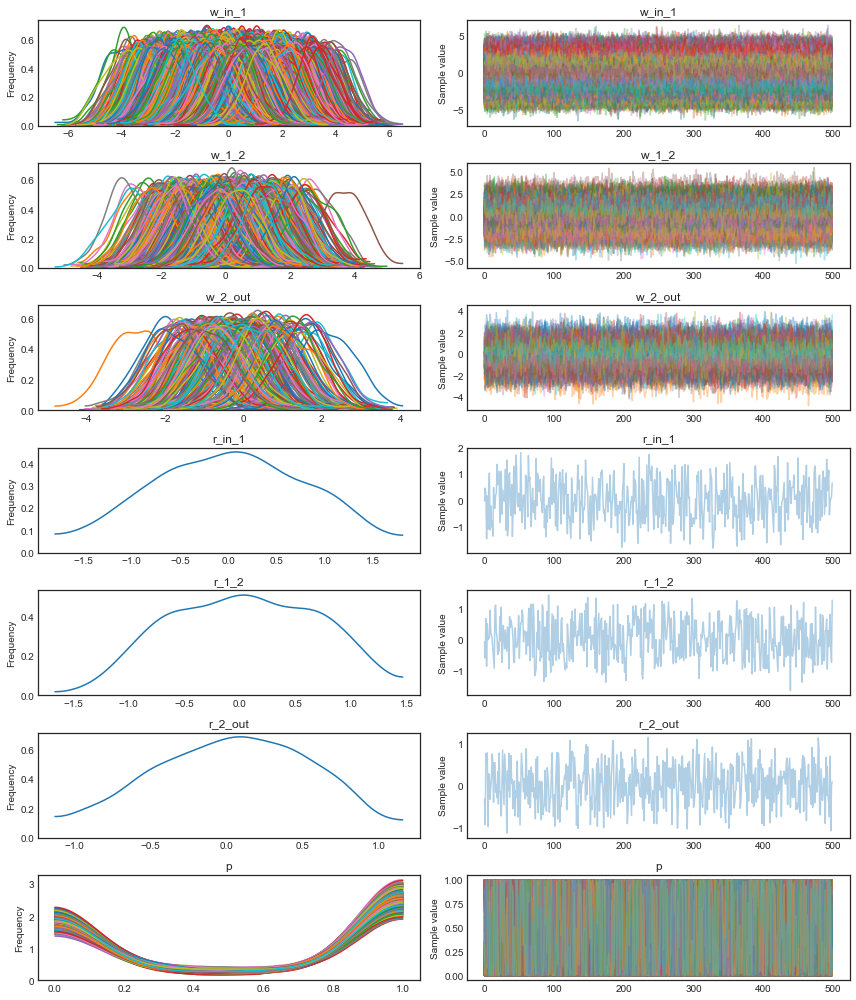

In [16]:
pm.traceplot(trace);

In [9]:
with neural_network:
    trace_ = pm.sample(1000)
    trace = trace_[500::2]

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = inf:   1%|          | 1323/200000 [00:17<47:21, 69.93it/s]
Interrupted at 1,325 [0%]: Average Loss = 3.513e+08


KeyboardInterrupt: 

In [7]:
trace.varnames

['r_in_1', 'r_1_2', 'r_2_out', 'w_in_1', 'w_1_2', 'w_2_out', 'p']

In [8]:
pm.traceplot(trace,varnames=['w_in_1','w_1_2'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145bf3a50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x144f89f90>]], dtype=object)

ValueError: Image size of -601262529x280 pixels is too large. It must be less than 2^16 in each direction.

In [9]:
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    advifit = pm.advi(n=30000)

 10%|▉         | 2994/30000 [00:48<07:53, 56.98it/s]Interrupted at 2,997 [9%]: Average ELBO = nan



In [6]:
with neural_network:
    step = pm.advi(n=100)
    trace = pm.variational.sample_vp(step, draws= 100)

    


Average ELBO = -4.2621e+05: 100%|██████████| 100/100 [00:01<00:00, 72.01it/s]
Finished [100%]: Average ELBO = -2.7983e+05
100%|██████████| 100/100 [00:00<00:00, 175.65it/s]


In [7]:
trace.varnames

['r_in_1', 'r_1_2', 'r_2_out', 'w_in_1', 'w_1_2', 'w_2_out', 'p']

In [ ]:
pm.traceplot(trace, varnames = ['w_in_1', 'w_1_2', 'w_2_out'])

KeyboardInterrupt: 

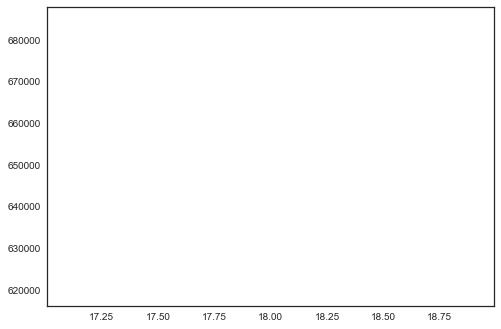

In [14]:
plt.plot(approx.hist[1:20])

In [15]:
# create symbolic input
x = T.matrix('X')

# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')

# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train_single[:10])
n.tag.test_value = 500
_sample_proba = approx.sample_node(neural_network.out.distribution.p, size=n,
                                   more_replacements={ann_input_minibatch:x})

sample_proba = theano.function([x, n], _sample_proba)

In [16]:
pred = sample_proba(X_test_multi,500)

In [17]:
pred.shape

(500, 200, 7)

In [18]:
pred_ = pred.mean(axis = 0)

In [19]:
pred_.shape

(200, 7)

In [20]:
a = pred_
a[np.arange(len(a)),a.argmax(1)] = -1 

a[np.arange(len(a)),a.argmax(1)] = 1

a[np.arange(len(a)),a.argmin(1)] = 1

a[a != 1] = 0

In [21]:
a[1]

array([ 0.,  0.,  0.,  1.,  1.,  0.,  0.])

In [22]:
from sklearn.metrics import *
print 'Hamming Loss:', hamming_loss(y_test, a)
print 'Convergence Error:', coverage_error(y_test, a)
print 'Label Ranking loss:', label_ranking_loss(y_test, a)
print 'F1-scores(Weighted)', f1_score(y_test, a, average='weighted')
print 'F1-scores(Micro)', f1_score(y_test, a, average='micro')
print 'F1-scores(Macro)', f1_score(y_test, a, average='macro')
print 'F1-scores(Samples)', f1_score(y_test, a, average='samples')
print 'Average Precision', average_precision_score(y_test,a)

Hamming Loss: 0.394285714286
Convergence Error: 6.625
Label Ranking loss: 0.746333333333
F1-scores(Weighted) 0.300820510545
F1-scores(Micro) 0.297709923664
F1-scores(Macro) 0.286144998457
F1-scores(Samples) 0.295833333333
Average Precision 0.385161567505


In [23]:
Uncert = pred.std(axis = 0)

In [24]:
b = Uncert

b[np.arange(len(b)), b.argmin(1)] = 2 

b[np.arange(len(b)), b.argmin(1)] = 1

b[np.arange(len(b)), b.argmax(1)] = 1

b[b != 1] = 0

In [25]:
from sklearn.metrics import *
print 'Hamming Loss:', hamming_loss(y_test, b)
print 'Convergence Error:', coverage_error(y_test, b)
print 'Label Ranking loss:', label_ranking_loss(y_test, b)
print 'F1-scores(Weighted)', f1_score(y_test, b, average='weighted')
print 'F1-scores(Micro)', f1_score(y_test, b, average='micro')
print 'F1-scores(Macro)', f1_score(y_test, b, average='macro')
print 'F1-scores(Samples)', f1_score(y_test, b, average='samples')
print 'Average Precision', average_precision_score(y_test,b)

Hamming Loss: 0.412857142857
Convergence Error: 6.8
Label Ranking loss: 0.781666666667
F1-scores(Weighted) 0.262244827246
F1-scores(Micro) 0.264631043257
F1-scores(Macro) 0.263838480356
F1-scores(Samples) 0.261666666667
Average Precision 0.384669890685


In [26]:

Uncert[12]

array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.])

In [27]:
softmax_prob = pred.mean(axis = 0)

In [28]:
softmax_prob[12]

array([ 0.18527234,  0.1172462 ,  0.16962341,  0.09797289,  0.21077832,
        0.06477749,  0.15432935])

In [29]:
a[7]

array([ 0.,  0.,  1.,  0.,  0.,  0.,  1.])

In [30]:
y_test[12]

array([1, 0, 0, 0, 1, 0, 0])

In [31]:
c = (softmax_prob / Uncert) 

In [32]:
c.shape

(200, 7)

In [33]:
c[12]

array([        inf,         inf,         inf,  0.09797289,         inf,
        0.06477749,         inf])

In [34]:
d = c
d[np.arange(len(d)),d.argmax(1)] = -1 

d[np.arange(len(d)),d.argmax(1)] = 1

d[np.arange(len(a)),d.argmin(1)] = 1

d[d != 1] = 0

In [35]:
from sklearn.metrics import *
print 'Hamming Loss:', hamming_loss(y_test, d)
print 'Convergence Error:', coverage_error(y_test, d)
print 'Label Ranking loss:', label_ranking_loss(y_test, d)
print 'F1-scores(Weighted)', f1_score(y_test, d, average='weighted')
print 'F1-scores(Micro)', f1_score(y_test, d, average='micro')
print 'F1-scores(Macro)', f1_score(y_test, d, average='macro')
print 'F1-scores(Samples)', f1_score(y_test, d, average='samples')
print 'Average Precision', average_precision_score(y_test,d)

Hamming Loss: 0.381428571429
Convergence Error: 6.475
Label Ranking loss: 0.7165
F1-scores(Weighted) 0.215686254789
F1-scores(Micro) 0.320610687023
F1-scores(Macro) 0.187409162175
F1-scores(Samples) 0.3225
Average Precision 0.528732351799


In [ ]:
trace = approx.sample(draws=1000)

In [161]:
trace

array([[ nan,   0.,   0., ...,  nan,  nan,  inf],
       [ inf,  nan,   0., ...,   0.,  nan,  nan],
       [  0.,   0.,  inf, ...,  nan,  nan,  inf],
       ..., 
       [ nan,   0.,  inf, ...,   0.,  nan,  nan],
       [  0.,  nan,  inf, ...,  nan,  nan,   0.],
       [ inf,  nan,  nan, ...,   0.,  inf,  nan]])